In [23]:
import csv
import pickle
import re

import numpy as np
import keras
import keras.layers
import keras.optimizers
import keras.callbacks
from keras.utils import pad_sequences, to_categorical
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from matplotlib import pyplot as plt


In [24]:
TO_EXCLUDE = '!"#$%&()*+-/:;<=>@[\\]^_`{|}~.,:;!?\t'
TO_TOKENIZE = '\n'

In [25]:
def load_data(file, include: str, exclude: str, size: int = None):
    _text =  []
    with open(file) as f:
        data = csv.reader(f)
        for verse, *_ in tqdm(list(data)[:size] if size is not None else list(data)):
            # Separate characters that we want to tokenize
            correct_verse = re.sub(r'(['+include+'])', r' \1 ', verse)
            # Exclude characters that we do not want to tokenize
            correct_verse = correct_verse.translate(str.maketrans('', '', exclude))
            _text.append(correct_verse.lower())
    return _text

TEXT = load_data('data/poems/limericks.csv', TO_TOKENIZE, TO_EXCLUDE, 1000)
print(*TEXT[:3])

100%|██████████| 1000/1000 [00:00<00:00, 52632.75it/s]

cap'n jack was washed over the side 
 his crew searched but found not hair nor hide 
 no longer the helm 
 but the deep benthic realm 
 is where jack will forever reside 
  ablactation to wean off the breast 
 should wait 'til age 2 this is best 
 though some men never quit 
 bet you thought i'd rhyme tit 
 because they're mammarially obsessed 
  as a soup bisque is best when served hot 
 made with lobster it hits the right spot 
 i think it tastes dreamy 
 it's so rich and creamy 
 it's the soup you'd be served on a yacht 
 


In [26]:
TOKENIZER = Tokenizer(filters=TO_EXCLUDE)
TOKENIZER.fit_on_texts(TEXT)
TOTAL_WORDS = len(TOKENIZER.word_index) + 1
print(TOTAL_WORDS)

7609


In [27]:
def create_sequences(text, tokenizer):
    sequences = list()
    for verse in tqdm(text):
        # for line in verse.strip().split('\n'):
        encoded = tokenizer.texts_to_sequences([verse])[0]
        for i in range(1, len(encoded)):
            sequence = encoded[:i+1]
            sequences.append(sequence)
    return sequences

SEQUENCES = create_sequences(TEXT, TOKENIZER)
print(f"Total Sequences: {len(SEQUENCES)}")

100%|██████████| 1000/1000 [00:00<00:00, 17241.28it/s]

Total Sequences: 33262


In [28]:
SEQUENCE_LENGTH = max([len(seq) for seq in SEQUENCES])
ENCODED_SEQUENCES = pad_sequences(SEQUENCES, maxlen=SEQUENCE_LENGTH, padding='pre')
X, y = ENCODED_SEQUENCES[:,:-1], to_categorical(ENCODED_SEQUENCES[:,-1], num_classes=TOTAL_WORDS)
print(f'Max Sequence Length: {SEQUENCE_LENGTH}')

Max Sequence Length: 43


In [29]:
def create_model(total_words: int, sequence_length: int):
    # define model
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(total_words, 16, input_length=sequence_length - 1))
    model.add(keras.layers.LSTM(128, return_sequences=True, activation='relu'))
    model.add(keras.layers.LSTM(64, activation='relu'))
    model.add(keras.layers.Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

MODEL_NAME = "StructureModel"
MODEL_PATH = f"data/models/{MODEL_NAME}/weights.h5"
MODEL = keras.models.load_model(MODEL_PATH)
# MODEL = create_model(TOTAL_WORDS, SEQUENCE_LENGTH)
print(MODEL.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 42, 16)            121744    
                                                                 
 lstm (LSTM)                 (None, 42, 128)           74240     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 7609)              494585    
                                                                 
Total params: 739,977
Trainable params: 739,977
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
REVERSE_TOKEN_INDEX = {v: k for k, v in TOKENIZER.word_index.items()}

def generate_seq(model: keras.Model, tokenizer: Tokenizer, sequence_length: int, in_text: str, max_words: int = 60):
    for _ in range(max_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=sequence_length - 1, padding='pre')
        predicted = np.argmax(model.predict(encoded, verbose=0))
        out_word = REVERSE_TOKEN_INDEX.get(predicted, None)
        in_text += ' ' + out_word
    return in_text


In [9]:
def create_callbacks():
    callbacks = []

    class PredictionCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            frequency = 5
            if epoch % frequency == 0:
                seq = generate_seq(MODEL, TOKENIZER, SEQUENCE_LENGTH, "As a soup", 20)
                print(f"\n{seq}")

    callbacks.append(PredictionCallback())
    callbacks.append(keras.callbacks.EarlyStopping(monitor="loss", patience=3))
    callbacks.append(keras.callbacks.ModelCheckpoint(
        filepath=f"data/models/{MODEL_NAME}/checkpoint",
        save_weights_only=True,
        save_freq=5
    ))
    return callbacks


In [10]:
HISTORY = MODEL.fit(
    X,
    y,
    epochs=100,
    validation_split=0.1,
    verbose=1,
    batch_size=128,
    shuffle=True,
    callbacks=create_callbacks()
)

MODEL.save(MODEL_PATH)

Epoch 1/100
234/234 [==============================] - ETA: 0s - loss: 7.1269 - accuracy: 0.1401
As a soup 
 

234/234 [==============================] - 132s 548ms/step - loss: 7.1269 - accuracy: 0.1401 - val_loss: 6.8633 - val_accuracy: 0.1470
Epoch 2/100
234/234 [==============================] - 123s 527ms/step - loss: 6.5303 - accuracy: 0.1507 - val_loss: 7.0015 - val_accuracy: 0.1470
Epoch 3/100
234/234 [==============================] - 124s 530ms/step - loss: 6.4995 - accuracy: 0.1507 - val_loss: 7.1312 - val_accuracy: 0.1470
Epoch 4/100
234/234 [==============================] - 124s 530ms/step - loss: 6.4830 - accuracy: 0.1507 - val_loss: 7.1937 - val_accuracy: 0.1470
Epoch 5/100
234/234 [==============================] - 124s 531ms/step - loss: 6.4394 - accuracy: 0.1507 - val_loss: 7.1319 - val_accuracy: 0.1470
Epoch 6/100
234/234 [==============================] - ETA: 0s - loss: 6.2437 - accuracy: 0.1572
As a soup 
 the a a a a a 
 

234/234 [==============================

In [21]:
with open(f"data/models/{MODEL_NAME}/tokenizer.pickle", "wb") as f:
    pickle.dump(TOKENIZER, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"data/models/{MODEL_NAME}/history.pickle", "wb") as f:
    pickle.dump(HISTORY.history, f, protocol=pickle.HIGHEST_PROTOCOL)

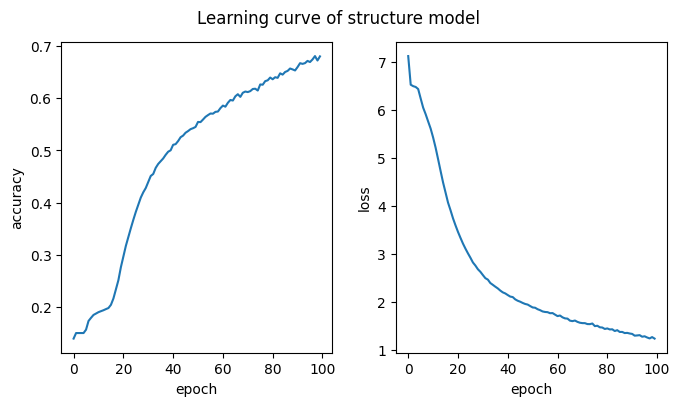

In [19]:
with open(f"data/models/{MODEL_NAME}/history.pickle", "rb") as f:
    history = pickle.load(f)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Learning curve of structure model")

ax1.plot(history['accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')

ax2.plot(history['loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
fig.tight_layout()
fig.set_size_inches(7, 4)
fig.savefig(f"data/models/{MODEL_NAME}/learning_curve.png")
plt.show()

In [31]:
print(generate_seq(MODEL, TOKENIZER, SEQUENCE_LENGTH, "Oh"))

Oh a shrub of played to carry 
 that i was form and saying out 
 to eternally galled 
 as my meeting up 
 you be points to his grin 
 and the number that be open we became die 
 i our vet when the book 
 long short it repeat 
 something where this which feet moon afar
